
LAYER 0: <keras.src.engine.input_layer.InputLayer object at 0x46443c460>
  - Input Shape: [(None, 28, 28, 1)]
  - Output Shape: [(None, 28, 28, 1)]

LAYER 1: <keras.src.layers.reshaping.flatten.Flatten object at 0x4645842e0>
  - Input Shape: (None, 28, 28, 1)
  - Output Shape: (None, 784)

LAYER 2: <__main__.CustomDense object at 0x464709f10>
  - Input Shape: (None, 784)
  - Output Shape: (None, 128)

LAYER 3: <__main__.CustomDense object at 0x464709220>
  - Input Shape: (None, 128)
  - Output Shape: (None, 10)
Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 1.0785 - accuracy: 0.8828 - val_loss: 0.3102 - val_accuracy: 0.9215
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2553 - accuracy: 0.9329 - val_loss: 0.3024 - val_accuracy: 0.9223
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2428 - accuracy: 0.9379 - val_loss: 0.2776 - val_accuracy: 0.9337
Epoch 4/20
1875/1875 [============================

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_32930/232828068.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


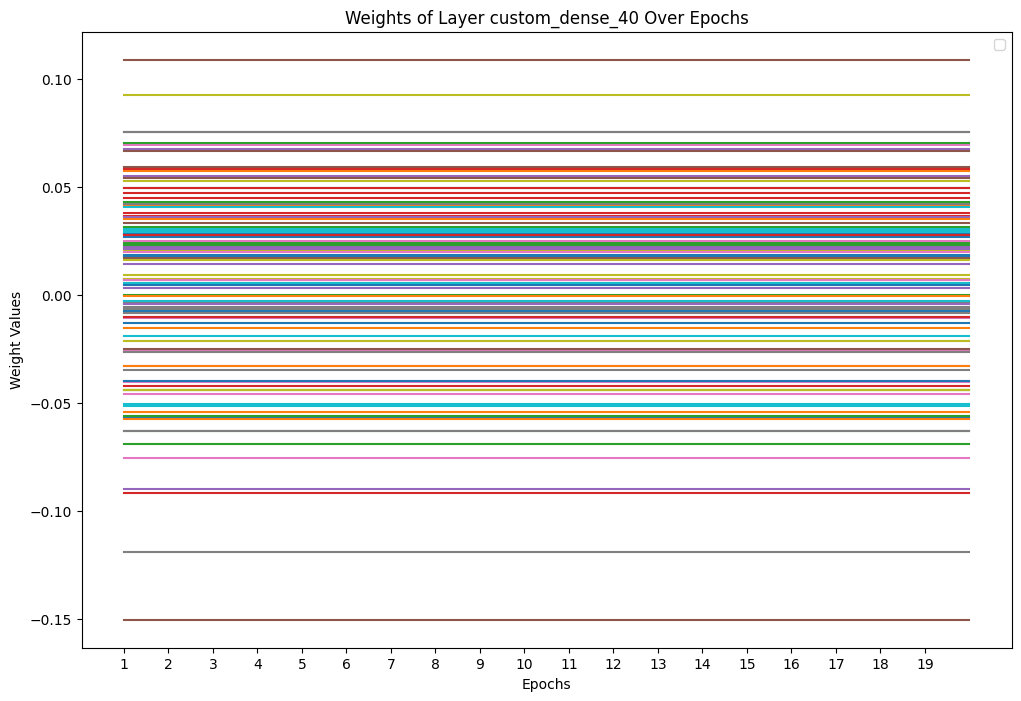

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1)  # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class CustomDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(CustomDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)

    def call(self, inputs):
        output = tf.matmul(inputs, self.w) + self.b

        if self.activation is not None:
            output = self.activation(output)
        return output
    
    def get_weigts(self):
        return self.w

input_layer = tf.keras.layers.Input(shape=(28, 28, 1))
flatten_layer = tf.keras.layers.Flatten()(input_layer)
dense_layer1 = CustomDense(128, activation='relu')(flatten_layer)
dense_layer2 = CustomDense(10, activation='softmax')(dense_layer1)

custom_dense_model = tf.keras.Model(inputs=input_layer, outputs=dense_layer2)

# Print layer details
for i, layer in enumerate(custom_dense_model.layers):
    print(f"\nLAYER {i}: {layer}")
    print(f"  - Input Shape: {layer.input_shape}")
    print(f"  - Output Shape: {layer.output_shape}")

custom_dense_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Custom callback to store the weights
class WeightLogger(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(WeightLogger, self).__init__()
        self.layer = layer
        self.weights_per_epoch = []

    def on_epoch_end(self, epoch, logs=None):
        weights = self.layer.w.numpy().flatten()
        self.weights_per_epoch.append(weights)

    def plot_weights(self):
        plt.figure(figsize=(12,8))
        num_of_weights = len(self.weights_per_epoch[0])
        print(num_of_weights)
#        for i in range(num_of_weights):
        for i in range(700,800):
            weight_trajectory = [w[i] for w in self.weights_per_epoch]
            plt.plot(range(1, len(self.weights_per_epoch) + 1), weight_trajectory)
        plt.xlabel('Epochs')
        plt.ylabel('Weight Values')
        plt.title(f'Weights of Layer {self.layer.name} Over Epochs')
        plt.legend()
        plt.xticks(range(1, len(self.weights_per_epoch)))
        plt.show()

weight_logger = WeightLogger(custom_dense_model.get_layer(index=2))

custom_dense_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[weight_logger]
)

# Evaluate the model
loss, accuracy = custom_dense_model.evaluate(x_test, y_test)
print(f'Custom Dense Model Test Accuracy: {accuracy}')

# Plot the weights for dense_layer1
weight_logger.plot_weights()
